In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import make_scorer, mean_squared_error
import time
import warnings
warnings.filterwarnings('ignore')

# Random seed
np.random.seed(42)

print("="*80)
print("STEP 5: HYPERPARAMETER OPTIMIZATION")
print("="*80)

STEP 5: HYPERPARAMETER OPTIMIZATION


In [2]:
# 5.1 LOADING AND PREPARE DATA
print("\n5.1 Loading data...")

demand = pd.read_csv('demand_clean.csv')
plants = pd.read_csv('plants_clean.csv')
costs = pd.read_csv('costs_clean.csv')

# Get features
demand_features = [col for col in demand.columns 
                   if col.startswith('DF') and col not in ['DF_region', 'DF_daytype']]
plant_features = [col for col in plants.columns if col.startswith('PF')]
all_features = demand_features + plant_features

# Combine data
combined = costs.copy()
combined = combined.merge(demand[['Demand ID'] + demand_features], on='Demand ID')
combined = combined.merge(plants[['Plant ID'] + plant_features], on='Plant ID')

# Prepare X, y, groups
X = combined[all_features].values
y = combined['Cost_USD_per_MWh'].values
groups = combined['Demand ID'].values

print(f"Data ready: X{X.shape}, y{y.shape}, {len(np.unique(groups))} groups")





5.1 Loading data...
Data ready: X(24000, 30), y(24000,), 500 groups


In [3]:
# 5.2 DEFINING HYPERPARAMETER GRID
print("\n5.2 Defining hyperparameter grid...")

# Define grid (keeping it small for speed)
param_grid = {
    'n_estimators': [50, 100],        # 2 values
    'max_depth': [15, 25],            # 2 values
    'min_samples_split': [2, 5],      # 2 values
    'min_samples_leaf': [1, 2]        # 2 values
}

# Calculate total combinations
total_combos = 1
for param, values in param_grid.items():
    total_combos *= len(values)

print(f"\nParameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

print(f"\nTotal combinations to test: {total_combos}")
print(f"With 5-fold CV: {total_combos * 5} model trainings")


5.2 Defining hyperparameter grid...

Parameter grid:
  n_estimators: [50, 100]
  max_depth: [15, 25]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]

Total combinations to test: 16
With 5-fold CV: 80 model trainings


In [4]:
# 5.3 DEFINING CUSTOM SCORER
print("\n5.3 Setting up custom scorer...")

def custom_rmse(y_true, y_pred):
    """Calculate RMSE (lower is better)"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return -rmse  # Negative because sklearn maximizes

scorer = make_scorer(custom_rmse, greater_is_better=True)
print(" Custom RMSE scorer created")



5.3 Setting up custom scorer...
 Custom RMSE scorer created


In [5]:
# 5.4 PERFORM GRID SEARCH
print("\n5.4 Running GridSearchCV...")

print(f"\nThis will take several minutes...")
print("="*80)

# Use GroupKFold (5 folds) instead of LOGO for speed
cv_strategy = GroupKFold(n_splits=5)

# Create base model
base_model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring=scorer,
    n_jobs=1,           # Run 1 at a time to show progress
    verbose=2,          # Show progress
    return_train_score=True
)

# Run GridSearch
print(f"\n Starting GridSearch at {time.strftime('%H:%M:%S')}...")
start_time = time.time()

grid_search.fit(X, y, groups=groups)

elapsed = time.time() - start_time
print(f"\n GridSearch complete in {elapsed:.1f} seconds ({elapsed/60:.2f} minutes)")


5.4 Running GridSearchCV...

This will take several minutes...

 Starting GridSearch at 15:32:59...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.6s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.4s
[CV] END max_depth=15, min_samples_

In [6]:
# 5.5 ANALYZING BEST PARAMETERS
print("\n5.5 Best hyperparameters found:")

print("\n" + "="*80)
print("BEST PARAMETERS")
print("="*80)

best_params = grid_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")

best_score = -grid_search.best_score_  # Convert back to positive RMSE
print(f"\nBest CV RMSE: ${best_score:.4f}")



5.5 Best hyperparameters found:

BEST PARAMETERS
  max_depth: 25
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100

Best CV RMSE: $10.5146


In [7]:
# 5.6 SHOW ALL RESULTS
print("\n5.6 All GridSearch results:")

# Get all results
results = pd.DataFrame(grid_search.cv_results_)
results['mean_rmse'] = -results['mean_test_score']
results = results.sort_values('mean_rmse')

print("\n" + "="*80)
print(f"TOP 5 PARAMETER COMBINATIONS (out of {len(results)})")
print("="*80)

# Show top 5
print("\nRank | RMSE    | n_est | depth | split | leaf")
print("-" * 60)
for i, (idx, row) in enumerate(results.head(5).iterrows(), 1):
    print(f"{i:4d} | ${row['mean_rmse']:6.2f} | "
          f"{int(row['param_n_estimators']):5d} | "
          f"{int(row['param_max_depth']):5d} | "
          f"{int(row['param_min_samples_split']):5d} | "
          f"{int(row['param_min_samples_leaf']):4d}")


5.6 All GridSearch results:

TOP 5 PARAMETER COMBINATIONS (out of 16)

Rank | RMSE    | n_est | depth | split | leaf
------------------------------------------------------------
   1 | $ 10.51 |   100 |    25 |     5 |    2
   2 | $ 10.53 |   100 |    25 |     2 |    2
   3 | $ 10.55 |    50 |    25 |     5 |    2
   4 | $ 10.56 |    50 |    25 |     2 |    2
   5 | $ 10.59 |   100 |    15 |     5 |    2


In [8]:
# 5.7 COMPAREING WITH PREVIOUS RESULTS
print("\n5.7 Comparison with previous steps:")

try:
    # Load previous results
    baseline = pd.read_csv('baseline_performance.csv')
    step3 = pd.read_csv('step3_results.csv')
    step4 = pd.read_csv('step4_summary.csv')
    
    baseline_best = baseline['RMSE'].min()
    step3_rmse = step3['custom_rmse'].values[0]
    step4_rmse = step4['cv_mean_rmse'].values[0]
    
    print("\n" + "="*80)
    print("PERFORMANCE PROGRESSION")
    print("="*80)
    print(f"Baseline (best plant): ${baseline_best:.4f}")
    print(f"Step 3 (train/test): ${step3_rmse:.4f}")
    print(f"Step 4 (LOGO CV): ${step4_rmse:.4f}")
    print(f"Step 5 (Optimized): ${best_score:.4f}")
    
    # Calculate improvements
    improvement_vs_baseline = ((baseline_best - best_score) / baseline_best) * 100
    improvement_vs_step4 = ((step4_rmse - best_score) / step4_rmse) * 100
    
    print(f"\nImprovements:")
    print(f"  vs Baseline: {improvement_vs_baseline:.2f}%")
    print(f"  vs Step 4: {improvement_vs_step4:.2f}%")
    
    if best_score < step4_rmse:
        print(f"\n Optimization improved by ${step4_rmse - best_score:.4f}")
    else:
        print(f"\n Default parameters were already good")
    
    # Store for saving
    baseline_val = baseline_best
    step3_val = step3_rmse
    step4_val = step4_rmse
    
except Exception as e:
    print(f"\n Could not load previous results: {e}")
    baseline_val = np.nan
    step3_val = np.nan
    step4_val = np.nan


5.7 Comparison with previous steps:

PERFORMANCE PROGRESSION
Baseline (best plant): $8.5280
Step 3 (train/test): $4.8377
Step 4 (LOGO CV): $7.2823
Step 5 (Optimized): $10.5146

Improvements:
  vs Baseline: -23.30%
  vs Step 4: -44.39%

 Default parameters were already good



5.8 Training final model with best parameters...
 Final model trained

Top 10 Most Important Features:
Feature  Importance
    PF5    0.078202
    PF7    0.070818
    DF9    0.059751
    DF3    0.055820
    DF8    0.053116
   DF10    0.048777
    DF2    0.045568
    DF4    0.045458
   DF12    0.044568
   PF16    0.043743

5.9 Creating visualizations...

FIGURE: GridSearch Results Heatmap
 Saved: fig_gridsearch_heatmap.png


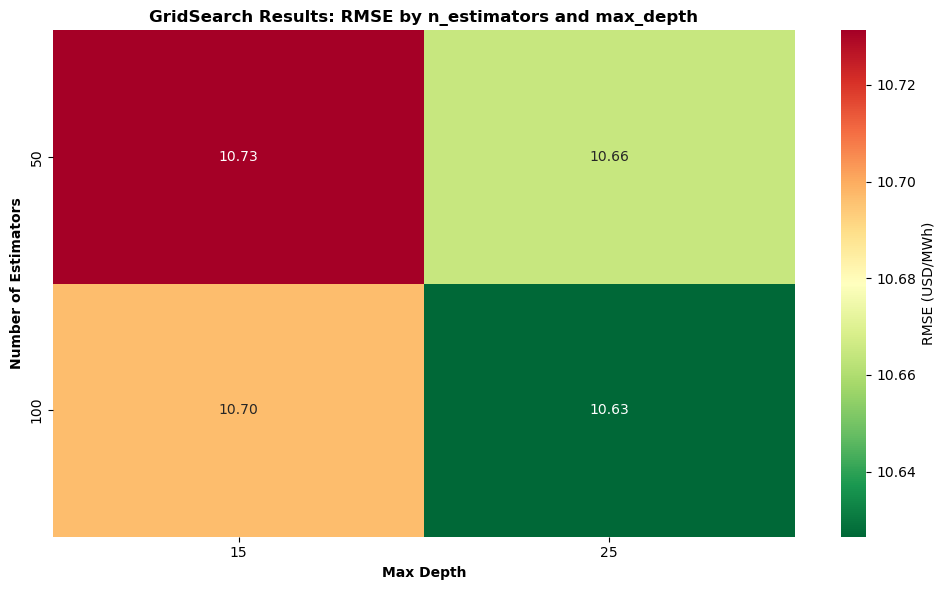

In [9]:
# 5.8 TRAIN FINAL MODEL WITH BEST PARAMETERS
print("\n5.8 Training final model with best parameters...")

final_model = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X, y)
print(" Final model trained")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': final_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))
print("\n5.9 Creating visualizations...")

print("\n" + "="*80)
print("FIGURE: GridSearch Results Heatmap")
print("="*80)

# Create a simple visualization of results
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for heatmap
# Group by n_estimators and max_depth (main parameters)
pivot_data = results.groupby(['param_n_estimators', 'param_max_depth'])['mean_rmse'].mean().reset_index()
pivot_table = pivot_data.pivot(index='param_n_estimators', columns='param_max_depth', values='mean_rmse')

# Create heatmap
import seaborn as sns
sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'RMSE (USD/MWh)'}, ax=ax)
ax.set_title('GridSearch Results: RMSE by n_estimators and max_depth', 
             fontweight='bold', fontsize=12)
ax.set_xlabel('Max Depth', fontweight='bold')
ax.set_ylabel('Number of Estimators', fontweight='bold')

plt.tight_layout()
# SAVE FIRST, THEN SHOW
plt.savefig('fig_gridsearch_heatmap.png', dpi=300, bbox_inches='tight')
print(" Saved: fig_gridsearch_heatmap.png")
plt.show()

In [10]:
# SAVE RESULTS
print("\n5.10 Saving results...")

# Save all GridSearch results
results_save = results[[col for col in results.columns 
                        if col.startswith('param_') or col.startswith('mean_') 
                        or col.startswith('std_') or col == 'rank_test_score']]
results_save.to_csv('step5_grid_results.csv', index=False)
print("Saved: step5_grid_results.csv")

# Save best parameters
best_params_df = pd.DataFrame([best_params])
best_params_df['best_cv_rmse'] = best_score
best_params_df['computation_time_seconds'] = elapsed
best_params_df.to_csv('step5_best_params.csv', index=False)
print(" Saved: step5_best_params.csv")

# Save feature importance
feature_importance.to_csv('step5_feature_importance.csv', index=False)
print(" Saved: step5_feature_importance.csv")

# Save comparison
if not np.isnan(baseline_val):
    comparison = pd.DataFrame({
        'baseline_best': [baseline_val],
        'step3_rmse': [step3_val],
        'step4_rmse': [step4_val],
        'step5_optimized_rmse': [best_score],
        'improvement_vs_baseline_pct': [improvement_vs_baseline],
        'computation_time_minutes': [elapsed / 60]
    })
    comparison.to_csv('step5_comparison.csv', index=False)
    print(" Saved: step5_comparison.csv")


5.10 Saving results...
Saved: step5_grid_results.csv
 Saved: step5_best_params.csv
 Saved: step5_feature_importance.csv
 Saved: step5_comparison.csv
